In [1]:
import numpy as np
import scipy.stats as ss
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from time import time
from polyagamma import random_polyagamma
import jax
from jax import lax
import jax.numpy as jnp
from jax.scipy.stats import norm
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
from typing import Callable, Dict, Optional, Tuple, Any
import jax
import jax.numpy as jnp
from jax import lax
import jax.scipy.linalg as jsp_linalg



# Modular Components

In [2]:
def jax_norm_logpdf(x, mu=0.0, sigma=1.0):
    """
    Elementwise log pdf of N(mu, sigma^2) for x (can be scalar or array).
    """
    x = jnp.asarray(x)
    mu = jnp.asarray(mu)
    sigma = jnp.asarray(sigma)
    return -0.5 * jnp.log(2.0 * jnp.pi) - jnp.log(sigma) - 0.5 * ((x - mu) / sigma) ** 2


def mvn_logpdf(x, mu, cov):
    """
    Log pdf of N(mu, cov) evaluated at x. Returns scalar.
    Uses Cholesky decomposition of cov for numerical stability.
    """
    x = jnp.asarray(x)
    mu = jnp.asarray(mu)
    cov = jnp.asarray(cov)
    D = mu.shape[0]
    L = jnp.linalg.cholesky(cov)
    diff = x - mu
    # solve L y = diff -> y = solve_triangular(L, diff)
    y = jsp_linalg.solve_triangular(L, diff, lower=True)
    quad = 0.5 * jnp.sum(y ** 2)
    # logdet = 2 * sum(log(diag(L)))
    logdet = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
    return -0.5 * (D * jnp.log(2.0 * jnp.pi) + logdet) - quad

def log_joint(a, b, t, Y, sa=10.0, sb=10.0):
    """
    Log joint under logistic regression hierarchical model:
      a ~ N(0, sa^2) per-column effect,
      b ~ N(0, sb^2) per-column intercept,
      t ~ N(0, 1) per-row effect (or similar).
    Y is P x I binary matrix (P rows, I columns).
    """
    la = jnp.sum(jax_norm_logpdf(a, 0.0, sa))
    lb = jnp.sum(jax_norm_logpdf(b, 0.0, sb))
    lt = jnp.sum(jax_norm_logpdf(t, 0.0, 1.0))
    logits = jnp.outer(t, a) + b[None, :]
    # numerically stable log-likelihood for Bernoulli with logit
    lY = jnp.sum(Y * jax.nn.log_sigmoid(logits) + (1.0 - Y) * jax.nn.log_sigmoid(-logits))
    return la + lb + lt + lY

def maximal_coupling_univariate(key, mu1, mu2, sigma1, sigma2):
    """
    Maximal coupling of N(mu1, sigma1^2) and N(mu2, sigma2^2).
    Returns (key, prop1, prop2).
    Algorithm:
      1. draw prop1 ~ N(mu1, sigma1^2).
      2. with probability min(1, p2(prop1)/p1(prop1)) set prop2 = prop1.
      3. otherwise draw prop2 ~ N(mu2, sigma2^2) by rejection sampling with acceptance prob p1(y)/p2(y).
    """
    sigma1 = jnp.asarray(sigma1)
    sigma2 = jnp.asarray(sigma2)

    # draw prop1
    key, subkey = jax.random.split(key)
    z = jax.random.normal(subkey)
    prop1 = mu1 + sigma1 * z

    # log densities at prop1
    logp1 = jax_norm_logpdf(prop1, mu1, sigma1)
    logp2 = jax_norm_logpdf(prop1, mu2, sigma2)

    key, subkey = jax.random.split(key)
    log_u = jnp.log(jax.random.uniform(subkey))

    # if accept immediate coupling
    if jnp.isfinite(logp1) and jnp.isfinite(logp2):
        cond_init = log_u < (logp2 - logp1)
    else:
        cond_init = False

    def make_prop2_equal(_):
        return prop1

    # rejection sampling for prop2
    def run_rejection(_key):
        def cond_fn(state):
            k, y, accept = state
            return jnp.logical_not(accept)

        def body_fn(state):
            k, _, _ = state
            k, sk = jax.random.split(k)
            z2 = jax.random.normal(sk)
            y = mu2 + sigma2 * z2
            logy_p1 = jax_norm_logpdf(y, mu1, sigma1)
            logy_p2 = jax_norm_logpdf(y, mu2, sigma2)
            k, sk2 = jax.random.split(k)
            log_u2 = jnp.log(jax.random.uniform(sk2))
            accept = log_u2 < (logy_p1 - logy_p2)
            return (k, y, accept)

        k0 = _key
        # initialize with a draw (so while_loop sees a real y)
        k0, sk0 = jax.random.split(k0)
        z0 = jax.random.normal(sk0)
        y0 = mu2 + sigma2 * z0
        k0, sk_init = jax.random.split(k0)
        log_u_init = jnp.log(jax.random.uniform(sk_init))
        init_accept = log_u_init < (jax_norm_logpdf(y0, mu1, sigma1) - jax_norm_logpdf(y0, mu2, sigma2))
        state0 = (k0, y0, init_accept)
        k_final, y_final, _ = lax.while_loop(cond_fn, body_fn, state0)
        return k_final, y_final

    key, prop2 = lax.cond(cond_init,
                          lambda _: (key, prop1),
                          run_rejection,
                          operand=key)
    return key, prop1, prop2

def maximal_coupling_multivariate(key, mu1, mu2, cov1, cov2):
    """
    Maximal coupling of N(mu1, cov1) and N(mu2, cov2).
    Returns (key, prop1, prop2).

    Procedure:
      - draw prop1 ~ N(mu1, cov1)
      - with probability min(1, p2(prop1)/p1(prop1)) set prop2 = prop1
      - otherwise rejection-sample prop2 ~ N(mu2, cov2) with acceptance prob p1(y)/p2(y)
    """
    key, subkey = jax.random.split(key)
    L1 = jnp.linalg.cholesky(cov1)
    z = jax.random.normal(subkey, shape=mu1.shape)
    prop1 = mu1 + L1 @ z

    logp1 = mvn_logpdf(prop1, mu1, cov1)
    logp2 = mvn_logpdf(prop1, mu2, cov2)

    key, subkey = jax.random.split(key)
    log_u = jnp.log(jax.random.uniform(subkey))
    cond_init = log_u < (logp2 - logp1)

    # immediate coupling
    def return_prop1(_):
        return prop1

    # rejection sampling for prop2 ~ N(mu2, cov2)
    def run_rejection(k):
        def cond_fn(state):
            k_, y_, accept_ = state
            return jnp.logical_not(accept_)

        def body_fn(state):
            k_, _, _ = state
            k_, sk = jax.random.split(k_)
            L2 = jnp.linalg.cholesky(cov2)
            z2 = jax.random.normal(sk, shape=mu2.shape)
            y = mu2 + L2 @ z2
            logy_p1 = mvn_logpdf(y, mu1, cov1)
            logy_p2 = mvn_logpdf(y, mu2, cov2)
            k_, sk2 = jax.random.split(k_)
            log_u2 = jnp.log(jax.random.uniform(sk2))
            accept = log_u2 < (logy_p1 - logy_p2)
            return (k_, y, accept)

        # initialize
        k0 = k
        k0, sk0 = jax.random.split(k0)
        L2 = jnp.linalg.cholesky(cov2)
        z0 = jax.random.normal(sk0, shape=mu2.shape)
        y0 = mu2 + L2 @ z0
        k0, sk_init = jax.random.split(k0)
        log_u_init = jnp.log(jax.random.uniform(sk_init))
        init_accept = log_u_init < (mvn_logpdf(y0, mu1, cov1) - mvn_logpdf(y0, mu2, cov2))
        state0 = (k0, y0, init_accept)
        k_final, y_final, _ = lax.while_loop(cond_fn, body_fn, state0)
        return k_final, y_final

    key_after, prop2 = lax.cond(cond_init,
                                lambda _: (key, prop1),
                                run_rejection,
                                operand=key)

    # ensure key is advanced (split once more)
    key_after, _ = jax.random.split(key_after)
    return key_after, prop1, prop2

def reflective_coupling_proposal(key, mu1, mu2, cov, jitter=1e-10):
    """
    Reflective coupling for proposals N(mu1, cov) and N(mu2, cov).
    Constructs proposals by sampling x ~ N(0, I) and mapping prop = mu + L @ x (L = cholesky(cov)).
    We perform reflection / shift in x-space using delta_x = L^{-1} @ (mu1 - mu2).
    """
    D = mu1.shape[0]
    cov = cov + jitter * jnp.eye(D)
    L = jnp.linalg.cholesky(cov)

    Delta_param = mu1 - mu2
    delta_x = jsp_linalg.solve_triangular(L, Delta_param, lower=True)

    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, shape=mu1.shape)

    key, subkey = jax.random.split(key)
    log_u = jnp.log(jax.random.uniform(subkey))

    def std_normal_logpdf(v):
        return -0.5 * (jnp.sum(v ** 2) + v.shape[0] * jnp.log(2.0 * jnp.pi))

    log_ratio = std_normal_logpdf(x + delta_x) - std_normal_logpdf(x)

    norm_val = jnp.linalg.norm(delta_x)
    e = jnp.where(norm_val > 0.0, delta_x / norm_val, jnp.zeros_like(delta_x))

    y = lax.cond(
        log_u <= log_ratio,
        lambda _x: _x + delta_x,
        lambda _x: _x - 2.0 * (e @ _x) * e,
        x
    )

    prop1 = mu1 + L @ x
    prop2 = mu2 + L @ y
    return key, prop1, prop2


def mh_update_vector(key, x1, x2, prop_sd_or_cov, Y1, Y2, log_joint_fn, curr_lp1, curr_lp2, method="maximal", coordinate=False):
    """
    Updates two coupled chains x1 and x2 either coordinate-wise or in-block.
    - If coordinate=True: prop_sd_or_cov is treated as scalar std for each 1D coordinate.
    - If not coordinate: prop_sd_or_cov may be
        * scalar: isotropic std -> cov = (prop_sd**2) * I
        * 1D array of per-dim stds: diag cov
        * 2D full covariance matrix: used directly
    log_joint_fn should accept a full vector x and return scalar log-joint.
    Returns (key, x1_new, x2_new, curr_lp1_new, curr_lp2_new, acc1, acc2)
    """
    D = x1.shape[0]
    acc1 = acc2 = 0

    # coordinate-wise update
    if coordinate:
        for d in range(D):
            mu1, mu2 = x1[d], x2[d]
            if method == "maximal":
                key, prop1, prop2 = maximal_coupling_univariate(key, mu1, mu2, prop_sd_or_cov, prop_sd_or_cov)
            elif method == "reflective":
                # scalar reflective: reflect sign of same normal draw
                key, subkey = jax.random.split(key)
                z = jax.random.normal(subkey)
                prop1 = mu1 + prop_sd_or_cov * z
                key, subkey = jax.random.split(key)
                coin = jax.random.uniform(subkey)
                prop2 = mu2 + prop_sd_or_cov * jnp.where(coin < 0.5, z, -z)
            else:
                raise ValueError("Unknown method")

            # MH step for coordinate
            lp_prop1 = log_joint_fn(x1.at[d].set(prop1))
            lp_prop2 = log_joint_fn(x2.at[d].set(prop2))
            key, subkey = jax.random.split(key)
            log_u = jnp.log(jax.random.uniform(subkey))
            accept1 = log_u < (lp_prop1 - curr_lp1)
            accept2 = log_u < (lp_prop2 - curr_lp2)
            x1 = jnp.where(accept1, x1.at[d].set(prop1), x1)
            x2 = jnp.where(accept2, x2.at[d].set(prop2), x2)
            curr_lp1 = jnp.where(accept1, lp_prop1, curr_lp1)
            curr_lp2 = jnp.where(accept2, lp_prop2, curr_lp2)
            acc1 += accept1.astype(jnp.int32)
            acc2 += accept2.astype(jnp.int32)

        return key, x1, x2, curr_lp1, curr_lp2, acc1, acc2

    # -------------------------
    # Block (multivariate) branch
    # -------------------------
    prop = jnp.asarray(prop_sd_or_cov)
    # 1) scalar
    if jnp.ndim(prop) == 0:
        cov = (prop ** 2) * jnp.eye(D)
    # 2) 1D array -> per-dim stds
    elif jnp.ndim(prop) == 1 and prop.shape[0] == D:
        cov = jnp.diag(prop ** 2)
    # 3) full covariance (DxD)
    elif jnp.ndim(prop) == 2 and prop.shape[0] == D and prop.shape[1] == D:
        cov = prop
    else:
        raise ValueError("prop_sd_or_cov must be scalar, 1D std array, or 2D covariance matrix matching dimension D")

    if method == "maximal":
        key, prop1, prop2 = maximal_coupling_multivariate(key, x1, x2, cov, cov)
    elif method == "reflective":
        key, prop1, prop2 = reflective_coupling_proposal(key, x1, x2, cov)
    else:
        raise ValueError("Unknown method")

    # single MH step for whole block
    lp_prop1 = log_joint_fn(prop1)
    lp_prop2 = log_joint_fn(prop2)
    key, subkey = jax.random.split(key)
    log_u = jnp.log(jax.random.uniform(subkey))
    accept1 = log_u < (lp_prop1 - curr_lp1)
    accept2 = log_u < (lp_prop2 - curr_lp2)
    x1 = jnp.where(accept1, prop1, x1)
    x2 = jnp.where(accept2, prop2, x2)
    curr_lp1 = jnp.where(accept1, lp_prop1, curr_lp1)
    curr_lp2 = jnp.where(accept2, lp_prop2, curr_lp2)
    acc1 += accept1.astype(jnp.int32)
    acc2 += accept2.astype(jnp.int32)

    return key, x1, x2, curr_lp1, curr_lp2, acc1, acc2

def mh_block_update_generic(key, a1, a2, b1, b2, t1, t2, Y1, Y2,
                            prop_sd_a, prop_sd_b, prop_sd_t,
                            curr_lp1, curr_lp2, method="maximal", coordinate=False):
    """
    Perform MH updates on blocks a, b, t for both coupled chains.
    Uses the global `log_joint` function defined above.
    Returns updated (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2).
    """
    # a-block
    key, a1, a2, curr_lp1, curr_lp2, acc_a1, acc_a2 = mh_update_vector(
        key, a1, a2, prop_sd_a, Y1, Y2, lambda prop: log_joint(prop, b1, t1, Y1), curr_lp1, curr_lp2, method, coordinate
    )
    # b-block
    key, b1, b2, curr_lp1, curr_lp2, acc_b1, acc_b2 = mh_update_vector(
        key, b1, b2, prop_sd_b, Y1, Y2, lambda prop: log_joint(a1, prop, t1, Y1), curr_lp1, curr_lp2, method, coordinate
    )
    # t-block
    key, t1, t2, curr_lp1, curr_lp2, acc_t1, acc_t2 = mh_update_vector(
        key, t1, t2, prop_sd_t, Y1, Y2, lambda prop: log_joint(a1, b1, prop, Y1), curr_lp1, curr_lp2, method, coordinate
    )
    return (key, a1, a2, b1, b2, t1, t2,
            curr_lp1, curr_lp2,
            acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2)

def run_coupled_mh_generic(Y_pair, n_iter=2000, lag=1,
                           prop_sd_a=0.5, prop_sd_b=0.5, prop_sd_t=0.2,
                           a_init=None, b_init=None, t_init=None,
                           method="maximal", coordinate=False, rng_seed=0):
    """
    Runs coupled MH for two chains (Y_pair is (Y1, Y2)).
    Returns traces (numpy arrays) and acceptance rates (dict).
    """
    Y1, Y2 = jnp.asarray(Y_pair[0]), jnp.asarray(Y_pair[1])
    P, I = Y1.shape

    # Initialize chains
    a1, a2 = (jnp.zeros(I), jnp.ones(I)) if a_init is None else a_init
    b1, b2 = (jnp.zeros(I), jnp.ones(I)) if b_init is None else b_init
    t1, t2 = (jnp.zeros(P), jnp.ones(P)) if t_init is None else t_init

    trace_a = jnp.zeros((2, n_iter, I))
    trace_b = jnp.zeros((2, n_iter, I))
    trace_t = jnp.zeros((2, n_iter, P))
    acc_a1 = acc_a2 = acc_b1 = acc_b2 = acc_t1 = acc_t2 = 0

    key = jax.random.PRNGKey(rng_seed)
    curr_lp1 = log_joint(a1, b1, t1, Y1)
    curr_lp2 = log_joint(a2, b2, t2, Y2)

    # -------------------------
    # Lag iterations: warm start chain 1 only
    # -------------------------
    for _ in range(lag):
        (key, a1, _, b1, _, t1, _, curr_lp1, _, *_rest) = mh_block_update_generic(
            key, a1, a1, b1, b1, t1, t1, Y1, Y1,
            prop_sd_a, prop_sd_b, prop_sd_t,
            curr_lp1, curr_lp1, method=method, coordinate=coordinate
        )
        # chain 2 discarded; only a1, b1, t1 and curr_lp1 are kept

    # -------------------------
    # Main coupled MH run
    # -------------------------
    def body(carry, i):
        (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
         acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2,
         trace_a, trace_b, trace_t) = carry

        (key, a1, a2, b1, b2, t1, t2,
         curr_lp1, curr_lp2,
         aa1, aa2, bb1, bb2, tt1, tt2) = mh_block_update_generic(
            key, a1, a2, b1, b2, t1, t2, Y1, Y2,
            prop_sd_a, prop_sd_b, prop_sd_t,
            curr_lp1, curr_lp2, method, coordinate
        )

        trace_a = trace_a.at[0, i, :].set(a1)
        trace_a = trace_a.at[1, i, :].set(a2)
        trace_b = trace_b.at[0, i, :].set(b1)
        trace_b = trace_b.at[1, i, :].set(b2)
        trace_t = trace_t.at[0, i, :].set(t1)
        trace_t = trace_t.at[1, i, :].set(t2)

        acc_a1 += aa1
        acc_a2 += aa2
        acc_b1 += bb1
        acc_b2 += bb2
        acc_t1 += tt1
        acc_t2 += tt2

        new_carry = (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
                     acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2,
                     trace_a, trace_b, trace_t)
        return new_carry, None

    carry_init = (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
                  acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2,
                  trace_a, trace_b, trace_t)

    carry_final, _ = lax.scan(body, carry_init, jnp.arange(n_iter))
    (key_f, a1_f, a2_f, b1_f, b2_f, t1_f, t2_f, curr_lp1_f, curr_lp2_f,
     acc_a1, acc_a2, acc_b1, acc_b2, acc_t1, acc_t2,
     trace_a, trace_b, trace_t) = carry_final

    # convert traces to numpy for easy postprocessing
    traces = {'a': np.array(trace_a), 'b': np.array(trace_b), 't': np.array(trace_t)}
    acc_rates = {
        'a': (float(acc_a1) / n_iter, float(acc_a2) / n_iter),
        'b': (float(acc_b1) / n_iter, float(acc_b2) / n_iter),
        't': (float(acc_t1) / n_iter, float(acc_t2) / n_iter)
    }
    return traces, acc_rates


# Tester Code

In [3]:
def generate_data(rng_seed: int = 0, P: int = 25, I: int = 10):
    rng = np.random.default_rng(rng_seed)
    true_a = rng.normal(0.5, 1.0, size=I)
    true_b = rng.normal(0.0, 1.0, size=I)
    true_theta = rng.normal(0.0, 1.0, size=P)
    lin = np.outer(true_theta, true_a) + true_b[None, :]
    prob = 1.0 / (1.0 + np.exp(-lin))
    Y = (rng.uniform(size=(P, I)) < prob).astype(np.int32)
    return Y, true_a, true_b, true_theta

def make_inits(P: int, I: int):
    a_init = (jnp.zeros(I), jnp.ones(I) * 2.0)
    b_init = (jnp.zeros(I), jnp.ones(I) * -2.0)
    t_init = (jnp.zeros(P), jnp.ones(P) * 1.5)
    return a_init, b_init, t_init

def build_block_prop_cov(prop_sd_a: float, prop_sd_b: float, prop_sd_t: float,
                         I: int, P: int, full: bool = True):
    a = (prop_sd_a ** 2) * jnp.ones(I)
    b = (prop_sd_b ** 2) * jnp.ones(I)
    t = (prop_sd_t ** 2) * jnp.ones(P)
    if full:
        return jnp.diag(jnp.concatenate([a, b, t]))
    else:
        return a, b, t

def normalize_traces_for_tester(traces: Dict[str, np.ndarray]) -> Tuple[Dict[str, np.ndarray], int]:
    normalized = {}
    n_chains = None
    for k, v in traces.items():
        arr = np.asarray(v)
        if arr.ndim == 2:
            normalized[k] = arr[None, ...]
            n_chains = 1 if n_chains is None else n_chains
        elif arr.ndim == 3:
            normalized[k] = arr
            n_chains = arr.shape[0] if n_chains is None else n_chains
        else:
            raise ValueError(f"Unexpected array ndim for traces['{k}']: {arr.shape}")
    return normalized, n_chains

def time_sampler(sampler_fn: Callable, *args, **kwargs) -> Tuple[Dict[str, np.ndarray], Optional[Dict[str, Any]], float]:
    t0 = time()
    out = sampler_fn(*args, **kwargs)
    t1 = time()
    if isinstance(out, tuple) and len(out) == 2:
        traces, acc = out
    else:
        traces, acc = out, None
    return traces, acc, t1 - t0

def find_meeting_time(
    traces: Dict[str, np.ndarray],
    tol: float = 1e-4,
    use_tqdm: bool = False,
) -> Optional[int]:
    traces_norm, n_chains = normalize_traces_for_tester(traces)
    if n_chains < 2:
        return None
    n_iter_actual = traces_norm['a'].shape[1]
    iterator = range(n_iter_actual)
    if use_tqdm:
        iterator = tqdm(iterator)
    for it in iterator:
        close_a = np.allclose(traces_norm['a'][0, it, :], traces_norm['a'][1, it, :], atol=tol)
        close_b = np.allclose(traces_norm['b'][0, it, :], traces_norm['b'][1, it, :], atol=tol)
        close_t = np.allclose(traces_norm['t'][0, it, :], traces_norm['t'][1, it, :], atol=tol)
        if close_a and close_b and close_t:
            return it
    return None

def summarize_results(
    traces: Dict[str, np.ndarray],
    acc: Optional[Dict[str, Any]],
    true_a: np.ndarray,
    true_b: np.ndarray,
    true_theta: np.ndarray,
    chain_idx: int = 0,
    first_n: int = 5,
    meeting_time: Optional[int] = 0,
):
    traces_norm, n_chains = normalize_traces_for_tester(traces)
    if chain_idx >= n_chains:
        chain_idx = 0
    a_tr_all = traces_norm['a'][chain_idx]
    b_tr_all = traces_norm['b'][chain_idx]
    t_tr_all = traces_norm['t'][chain_idx]
    a_hat_all = a_tr_all.mean(axis=0)
    b_hat_all = b_tr_all.mean(axis=0)
    theta_hat_all = t_tr_all.mean(axis=0)
    print("\nPosterior means (first {} over entire run):".format(first_n))
    print("a_hat[:]:", a_hat_all[:first_n])
    print("b_hat[:]:", b_hat_all[:first_n])
    print("theta_hat[:]:", theta_hat_all[:first_n])
    a_diff_all = a_hat_all - true_a
    b_diff_all = b_hat_all - true_b
    theta_diff_all = theta_hat_all - true_theta
    print("\nSummary of absolute differences (entire run):")
    print("Mean abs error a:", np.mean(np.abs(a_diff_all)))
    print("Mean abs error b:", np.mean(np.abs(b_diff_all)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff_all)))
    print("Max abs error a:", np.max(np.abs(a_diff_all)))
    print("Max abs error b:", np.max(np.abs(b_diff_all)))
    print("Max abs error theta:", np.max(np.abs(theta_diff_all)))
    if acc is not None:
        try:
            print("\nMean acceptance rates (chain 0):")
            print(" mean acc a:", np.mean(acc['a'][0]))
            print(" mean acc b:", np.mean(acc['b'][0]))
            print(" mean acc t:", np.mean(acc['t'][0]))
            print("\nMean acceptance rates (chain 1):")
            print(" mean acc a:", np.mean(acc['a'][1]))
            print(" mean acc b:", np.mean(acc['b'][1]))
            print(" mean acc t:", np.mean(acc['t'][1]))
        except Exception:
            print("\nAcceptance (raw):", acc)
    if meeting_time is None:
        return
    if meeting_time < 0:
        meeting_time = 0
    post_slice = slice(meeting_time, None)
    a_tr_post = a_tr_all[post_slice]
    b_tr_post = b_tr_all[post_slice]
    t_tr_post = t_tr_all[post_slice]
    if a_tr_post.size == 0 or b_tr_post.size == 0 or t_tr_post.size == 0:
        return
    a_hat_post = a_tr_post.mean(axis=0)
    b_hat_post = b_tr_post.mean(axis=0)
    theta_hat_post = t_tr_post.mean(axis=0)
    print("\nPosterior means (first {} ) after meeting_time={} :".format(first_n, meeting_time))
    print("a_hat[:]:", a_hat_post[:first_n])
    print("b_hat[:]:", b_hat_post[:first_n])
    print("theta_hat[:]:", theta_hat_post[:first_n])
    a_diff_post = a_hat_post - true_a
    b_diff_post = b_hat_post - true_b
    theta_diff_post = theta_hat_post - true_theta
    print("\nSummary of absolute differences (after meeting):")
    print("Mean abs error a:", np.mean(np.abs(a_diff_post)))
    print("Mean abs error b:", np.mean(np.abs(b_diff_post)))
    print("Mean abs error theta:", np.mean(np.abs(theta_diff_post)))
    print("Max abs error a:", np.max(np.abs(a_diff_post)))
    print("Max abs error b:", np.max(np.abs(b_diff_post)))
    print("Max abs error theta:", np.max(np.abs(theta_diff_post)))
    if acc is not None:
        try:
            post_ok = (isinstance(acc['a'][0], np.ndarray) and acc['a'][0].size >= meeting_time)
        except Exception:
            post_ok = False
        if post_ok:
            post_slice = slice(meeting_time, None)
            print("\nMean acceptance rates after meeting (chain 0):")
            print(" mean acc a:", np.mean(acc['a'][0][post_slice]))
            print(" mean acc b:", np.mean(acc['b'][0][post_slice]))
            print(" mean acc t:", np.mean(acc['t'][0][post_slice]))
            print("\nMean acceptance rates after meeting (chain 1):")
            print(" mean acc a:", np.mean(acc['a'][1][post_slice]))
            print(" mean acc b:", np.mean(acc['b'][1][post_slice]))
            print(" mean acc t:", np.mean(acc['t'][1][post_slice]))

def plot_traces(traces: Dict[str, np.ndarray], chain_idx: int = 0):
    traces_norm, _ = normalize_traces_for_tester(traces)
    idata = az.from_dict(
        posterior={
            "a": traces_norm['a'][chain_idx][None, :, :],
            "b": traces_norm['b'][chain_idx][None, :, :],
            "t": traces_norm['t'][chain_idx][None, :, :]
        }
    )
    az.plot_trace(idata, var_names=["a", "b", "t"])
    plt.tight_layout()
    plt.show()

def run_test_for_sampler(
    sampler_fn: Callable,
    sampler_args: tuple,
    sampler_kwargs: dict,
    rng_seed: int = 0,
    P: int = 25,
    I: int = 10,
    find_meeting: bool = True,
    meeting_tol: float = 1e-4,
    use_tqdm: bool = False,
    chain_idx: int = 0,
):
    Y, true_a, true_b, true_theta = generate_data(rng_seed=rng_seed, P=P, I=I)
    print("Running sampler...")
    t0 = time()
    out = sampler_fn(*sampler_args, **sampler_kwargs)
    t1 = time()
    elapsed = t1 - t0
    if isinstance(out, tuple) and len(out) == 2:
        traces, acc = out
    else:
        traces, acc = out, None
    print(f"\nSampler runtime: {elapsed:.2f} seconds\n")
    meeting_time_to_use: Optional[int] = 0
    if find_meeting:
        mt = find_meeting_time(traces, tol=meeting_tol, use_tqdm=use_tqdm)
        if mt is not None:
            print(f"\nChains approximately met at iteration (0-based): {mt}")
            meeting_time_to_use = mt
        else:
            print("\nChains did NOT meet (or single-chain sampler); using meeting_time = 0.")
    summarize_results(traces, acc, true_a, true_b, true_theta,
                      chain_idx=chain_idx, first_n=5, meeting_time=meeting_time_to_use)
    try:
        plot_traces(traces, chain_idx=chain_idx)
    except Exception as e:
        print("Trace plotting failed:", e)

def da_wrapper(Y_local, n_iter=2000, blocking=True, mu_a=1.2, sigma_a2=100.0, sigma_b2=100.0, seed=None):
    traces = DA_IRT_python(Y_local, n_iter=n_iter, blocking=blocking,
                           mu_a=mu_a, sigma_a2=sigma_a2, sigma_b2=sigma_b2, seed=seed)
    return traces

# IRT Model

$I$ multiple choice questions

$Y_{p, i} = 1$ is student $p \in \{1, \ldots, P\}$ has the correct answer on item $i \in [I]$.

$$Y_{p, i}|a, b, \theta \overset{\text{indep.}}{\sim} Bern(\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}})$$

$$a_i \overset{\text{i.i.d.}}{\sim} N(0, \sigma_a^2)$$

$$b_i \overset{\text{i.i.d.}}{\sim} N(0, \sigma_b^2)$$

$$\theta_p \sim N(0, 1)$$

Let $\sigma_a^2 = \sigma_b^2 = 100$, $\Psi = (a, b, \theta)$.

$$\pi(\Psi|y) \propto \exp(- \frac{1}{2\sigma_a^2} \|a\|^2 - \frac{1}{2\sigma_b^2}\|b\|^2 - \frac{1}{2}\|\theta\|^2 + \sum_{p, i} y_{p, i}(a_i\theta_p + b_i) - \log(1 + \exp(a_i\theta_p + b_i))$$

Equivalently, notice

$$\log\pi(\Psi | y) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(a_i) + \log p(b_i) + \log p(\theta_p)$$


With conditionals:

$$\log \pi(a_i| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(a_i) $$
$$= P\sum_i\log p(a_i) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

$$\log \pi(b_i| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(b_i)$$

$$= P\sum_i\log p(b_i) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

$$\log \pi(\theta_p| \cdot) = \sum_p\sum_i \log p(y_{p, i}|a, b, \theta) + \log p(\theta_p)$$

$$= I\sum_p \log p(\theta_p) + \sum_p\sum_i \log p(y_{p, i}|a, b, \theta)$$

Unfortunately, none of these have a closed form.

## PolyaGamma augmentation

A PolyaGamma data augmentation allows us to directly solve this using Gibbs sampling:

$$\pi(w, \Psi|y) \propto p(a, b, \theta) \prod_{p, i} \exp[(y_{p, i} - \frac{1}{2})(a_i\theta_p + b_i) - \frac{w_{p, i}}{2}(a_i\theta_p + b_i)^2]g_0(w_{p, i})$$

where $g_0(w) = \sum_{k = 0}^\infty (-1)^k \frac{(2k + 1)}{\sqrt{2\pi w^3}}\exp(- \frac{(k + 1)^2}{8w}) \mathbb{1}_{(0, \infty)}(w)$.

This leads to conditionals:

$$W_{p, i}| a_i, \theta_p, b_i, y_{p, i} \sim PolyaGamma(1, a_i\theta_p + b_i)$$

$$a_i|w_{\cdot, i}, \theta_p, b_i, y_{p, i} \sim N(m_i, u_i^2)$$

$$b_i|w_{\cdot, i}, \theta_p, a_i, y_{p, i} \sim N(n_i, v_i^2)$$

$$\theta_p|w_{p, \cdot}, a_i, b_i, y_{p, i} \sim N(o_p, x_p^2)$$

where 

$$u_i = (\frac{1}{\sigma_a^2} + \sum_{p \in [P]} w_{p, i}\theta_p^2)^{-1}$$

$$m_i = u_i^2\sum_{p \in [P]}\theta_p(y_{p, i} - 0.5 - b_iw_{p, i})$$

$$v_i = (\frac{1}{\sigma_b^2} + \sum_{p \in [P]} w_{p, i})^{-1}$$

$$n_i = v_i^2\sum_{p \in [P]} (y_{p, i} - 0.5 - a_i\theta_pw_{p, i})$$

$$x_p^2 = (1 + \sum_{i \in [I]}w_{p, i}a_i^2)^{-1}$$

$$o_p = x_p^2 \sum_{i \in [I]} a_i(y_{p, i} - 0.5 - b_iw_{p, i})$$

Additionally since $a_i$ and $b_i$ are strongly correlated, we update them jointly.

Let $U \in \mathbb{R}^{2I}$ and $V \in \mathbb{R}^{2I \times 2I}$ where

$$U_i = \sum_{p \in [P]}(y_{p, i} - 0.5)\theta_p$$

$$U_{i + p} = \sum_{p \in [P]}(y_{p, i} - 0.5)$$

$$D_{i, j} = \begin{cases} \frac{1}{\sigma_a^2} + \sum_{p \in [P]} W_{p, i} \theta_p^2 &, \text{ if } i = j \text{ and } i \leq I\\ \frac{1}{\sigma_b^2} + \sum_{p \in [P]} W_{p, i} &, \text{ if } i = j \text{ and } I + 1 \leq i \leq 2I\\ \sum_{p \in [P]} \theta_pW_{p, i} &, \text{ if } |j - i| = p\\ 0 &, \text{ otherwise} \end{cases}$$

$$\begin{pmatrix} a\\b \end{pmatrix}|w, \theta, y \sim N(D^{-1}U, D^{-1})$$

In [4]:
def DA_IRT_python(Y, n_iter=1000, blocking=True, mu_a=1.2, sigma_a2=100.0, sigma_b2=100.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    P, I = Y.shape
    a = np.ones(I)
    b = np.zeros(I)
    theta = 0.1 * np.ones(P)
    W = np.zeros((P, I))
    res_a = np.zeros((n_iter, I))
    res_b = np.zeros((n_iter, I))
    res_theta = np.zeros((n_iter, P))
    
    for k in range(n_iter):
        # Sample W
        for i in range(I):
            z = a[i]*theta + b[i]
            W[:, i] = random_polyagamma(z=z, size=P, method="devroye")
        
        # Sample theta
        for p in range(P):
            vsq = 1 / (1 + np.sum(W[p, :] * a**2))
            m = vsq * np.sum(a * (Y[p, :] - 0.5) - W[p, :] * a * b)
            theta[p] = m + np.sqrt(vsq) * np.random.randn()
        
        # Sample (a, b)
        if blocking:
            U1 = theta @ (Y - 0.5)
            U2 = np.sum(Y - 0.5, axis=0)
            cp1 = np.sum(W, axis=0)
            cp2 = theta @ W
            cp3 = theta**2 @ W
            for i in range(I):
                D = np.array([[1/sigma_a2 + cp3[i], cp2[i]],
                              [cp2[i], 1/sigma_b2 + cp1[i]]])
                U = np.array([U1[i], U2[i]])
                L = np.linalg.cholesky(D)
                mean = np.linalg.solve(D, U)
                z = np.random.randn(2)
                ab_sample = mean + np.linalg.solve(L.T, z)
                a[i], b[i] = ab_sample[0], ab_sample[1]
        else:
            for i in range(I):
                vsq = 1 / (1/sigma_a2 + np.sum(W[:, i] * theta**2))
                m = vsq * np.sum(theta * (Y[:, i] - 0.5 - b[i]*W[:, i]))
                a[i] = m + np.sqrt(vsq)*np.random.randn()
                vsq = 1 / (1/sigma_b2 + np.sum(W[:, i]))
                m = vsq * np.sum(Y[:, i] - 0.5 - a[i]*W[:, i]*theta)
                b[i] = m + np.sqrt(vsq)*np.random.randn()
        
        if (k+1) % 1000 == 0 or k == 0:
            print(f"Iteration {k+1}/{n_iter} complete")
        
        res_a[k, :] = a
        res_b[k, :] = b
        res_theta[k, :] = theta
    
    return {"a": res_a, "b": res_b, "t": res_theta}



Running sampler...
Iteration 1/20000 complete
Iteration 1000/20000 complete
Iteration 2000/20000 complete
Iteration 3000/20000 complete
Iteration 4000/20000 complete
Iteration 5000/20000 complete
Iteration 6000/20000 complete
Iteration 7000/20000 complete
Iteration 8000/20000 complete
Iteration 9000/20000 complete
Iteration 10000/20000 complete
Iteration 11000/20000 complete
Iteration 12000/20000 complete
Iteration 13000/20000 complete
Iteration 14000/20000 complete
Iteration 15000/20000 complete
Iteration 16000/20000 complete
Iteration 17000/20000 complete
Iteration 18000/20000 complete
Iteration 19000/20000 complete
Iteration 20000/20000 complete

Sampler runtime: 367.89 seconds


Posterior means (first 5 over entire run):
a_hat[:]: [-0.50494611 -0.03468138  2.02934325  0.87654418  1.5312923 ]
b_hat[:]: [-0.44827879  1.68666318 -0.3703041  -1.67826417 -0.27193071]
theta_hat[:]: [-1.41927325 -0.79854744 -0.26791115  1.00089542  1.68047882]

Summary of absolute differences (entire run)

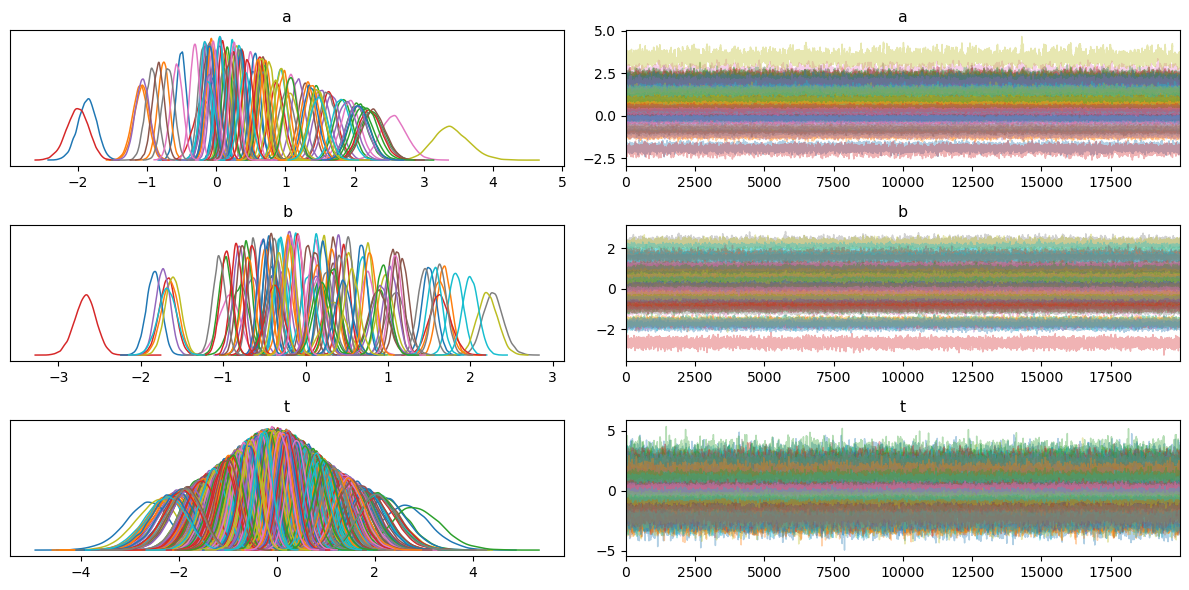

In [5]:
P, I = 1000, 100
rng_seed = 123
rng = np.random.default_rng(rng_seed)
Y, true_a, true_b, true_theta = generate_data(rng_seed, P, I)

sampler_args = (Y,)
sampler_kwargs = dict(n_iter=20000, blocking=True, seed=123)

run_test_for_sampler(da_wrapper, sampler_args, sampler_kwargs,
                     rng_seed=rng_seed, P=P, I=I,
                     find_meeting=False)



# Coupling

## Maximal Coupling

Sample a couple $p$ and $q$ with parameter $\eta \in (0, 1]$. The coupling maximizes $P(X = Y)$ when $\eta = 1$, but the variance of the cost is bounded when $\eta < 1$.

1. Sample $X \sim p$
2. Sample $W \sim Unif(0, 1)$

    (a) If $W \leq \min(\eta, \frac{q(X)}{p(X)})$. Set $Y = X$

    (b) Otherwise sample $Y^* \sim q$ and $W^* \sim Unif(0, 1)$ until $W^* > \eta\frac{p(Y^*)}{q(Y^*)}$, and set $Y = Y^*$
4. Return $(X, Y)$.


## Reflective Coupling

A coupling for distributions $p$ and $q$ obtained from a common spherically symmetric distribution $s$, rescaled with a common covariance $\Sigma$, and shifted by $\mu_1$ and $\mu_2$ respectively. For example $p = N(\mu_1, \Sigma)$ and $q = N(\mu_2, \Sigma)$ if $s = N(0, I)$.

1. Let $\Delta = \Sigma^{-\frac{1}{2}}(\mu_1 - \mu_2)$ and $e = \frac{\Delta}{|\Delta|}$ where $|\cdot|$ is the $L_2$ norm.

2. Sample $\tilde{X} \sim s$, and $W \sim Unif(0, 1)$.

    (a) If $s(\tilde{X})W \leq s(\tilde{X} + \Delta)$, set $\tilde{Y} = \tilde{X} + \Delta$.


    (b) Else set $\tilde{Y} = \tilde{X} - 2(e^T\tilde{X})e$

4. Set $X = \Sigma^{\frac{1}{2}}\tilde{X} + \mu_1$, $Y = \Sigma^{\frac{1}{2}}\tilde{Y} + \mu_2$, and return $(X, Y)$.

## Test

In [6]:
def run_all_sampler_scenarios(Y, n_iter=2000, lag=1, prop_sd_a=0.03, prop_sd_b=0.03, prop_sd_t=0.18, rng_seed=0):
    scenarios = [
        #{"name": "Coordinate Maximal", "coordinate": True, "method": "maximal"},
        #{"name": "Block Maximal",      "coordinate": False, "method": "maximal"},
        {"name": "Block Reflective",      "coordinate": False, "method": "reflective"}
    ]

    for sc in scenarios:
        print("\n" + "="*80)
        print(f"Running scenario: {sc['name']}")
        print("="*80 + "\n")

        # Initialize chains
        a_init, b_init, t_init = make_inits(P=Y.shape[0], I=Y.shape[1])
        sampler_kwargs = {
            "n_iter": n_iter,
            "lag": lag,
            "prop_sd_a": prop_sd_a,
            "prop_sd_b": prop_sd_b,
            "prop_sd_t": prop_sd_t,
            "a_init": a_init,
            "b_init": b_init,
            "t_init": t_init,
            "method": sc["method"],
            "coordinate": sc["coordinate"],
            "rng_seed": rng_seed
        }

        run_test_for_sampler(
            sampler_fn=run_coupled_mh_generic,
            sampler_args=((Y, Y),),  # coupled chains on same Y for testing
            sampler_kwargs=sampler_kwargs,
            rng_seed=rng_seed,
            P=Y.shape[0],
            I=Y.shape[1],
            find_meeting=True,
            meeting_tol=1e-4
        )


Running scenario: Block Reflective

Running sampler...

Sampler runtime: 375.02 seconds


Chains approximately met at iteration (0-based): 829032

Posterior means (first 5 over entire run):
a_hat[:]: [-1.2499127 -3.2100713  3.8115268]
b_hat[:]: [ 3.4505603 -7.853795  -3.849902 ]
theta_hat[:]: [-0.45352495 -0.08403061  0.1259246   0.3422787  -0.07895692]

Summary of absolute differences (entire run):
Mean abs error a: 2.4285975390565864
Mean abs error b: 3.6534926285361666
Mean abs error theta: 0.6159366619957753
Max abs error a: 2.6700872190616285
Max abs error b: 5.90275986292087
Max abs error theta: 1.2086403944136734

Mean acceptance rates (chain 0):
 mean acc a: 0.9861358
 mean acc b: 0.9840599
 mean acc t: 0.5105718

Mean acceptance rates (chain 1):
 mean acc a: 0.9214285
 mean acc b: 0.9196566
 mean acc t: 0.5032331

Posterior means (first 5 ) after meeting_time=829032 :
a_hat[:]: [-1.1805625 -2.6228423  3.1808703]
b_hat[:]: [ 3.5547984 -7.6124544 -3.7287576]
theta_hat[:]: [-0.3

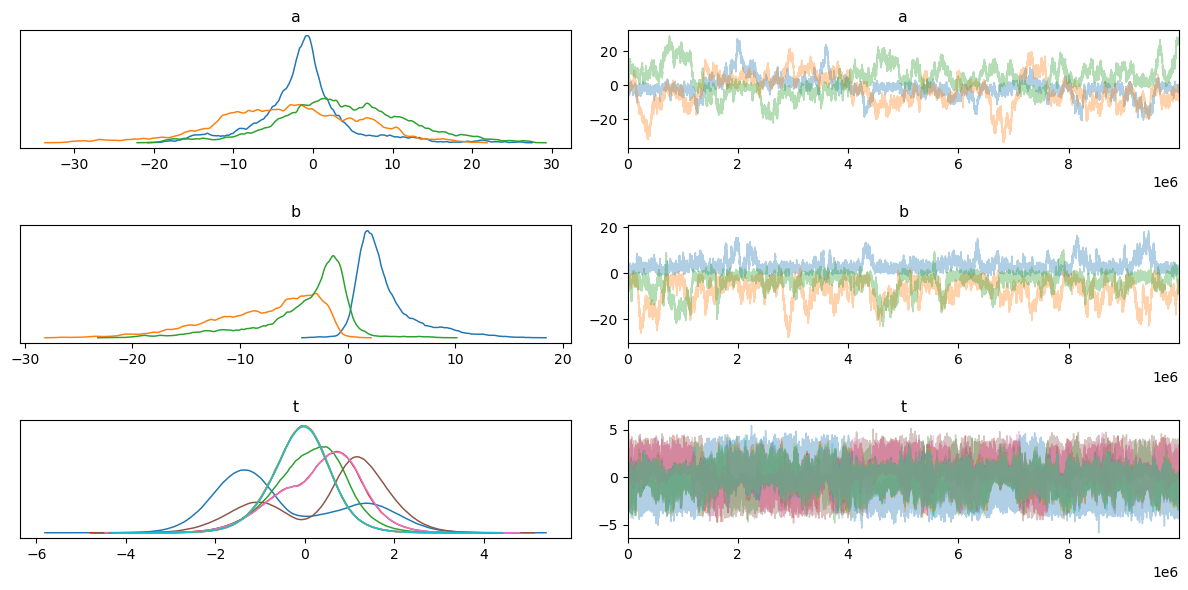

In [12]:
Y, true_a, true_b, true_theta = generate_data(rng_seed=42, P=10, I=3)
run_all_sampler_scenarios(Y, n_iter=10000000, lag=1, prop_sd_a=0.03, prop_sd_b=0.03, prop_sd_t=0.18, rng_seed=42)


# Debiasing samples

The strategy is that we implement a scheduler so that way we can imitate a Pythonic while loop

In [9]:
def run_coupled_mh_scheduler(
    Y_pair,
    chunk_size: int = 100_000,
    max_chunks: int = 10,
    prop_sd_a: float = 0.5,
    prop_sd_b: float = 0.5,
    prop_sd_t: float = 0.2,
    a_init=None,
    b_init=None,
    t_init=None,
    method="maximal",
    coordinate=False,
    rng_seed=0,
    tol=1e-4
):
    """
    Run coupled chains in batched chunks until meeting or max_chunks reached.
    Returns full trace and meeting time.
    """
    Y1, Y2 = jnp.asarray(Y_pair[0]), jnp.asarray(Y_pair[1])
    P, I = Y1.shape

    # Initialize chains
    a1, a2 = (jnp.zeros(I), jnp.ones(I)) if a_init is None else a_init
    b1, b2 = (jnp.zeros(I), jnp.ones(I)) if b_init is None else b_init
    t1, t2 = (jnp.zeros(P), jnp.ones(P)) if t_init is None else t_init

    # Initialize accumulators for trace
    trace_a = []
    trace_b = []
    trace_t = []

    key = jax.random.PRNGKey(rng_seed)
    curr_lp1 = log_joint(a1, b1, t1, Y1)
    curr_lp2 = log_joint(a2, b2, t2, Y2)

    meeting_time = None
    total_iters = 0

    # JIT-ed sampler for a chunk
    @jax.jit
    def sampler_chunk(a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, key, n_iter):
        def body(carry, i):
            key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a, trace_b, trace_t = carry
            key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, _, _, _, _, _, _, _ = mh_block_update_generic(
                key, a1, a2, b1, b2, t1, t2, Y1, Y2,
                prop_sd_a, prop_sd_b, prop_sd_t,
                curr_lp1, curr_lp2, method=method, coordinate=coordinate
            )
            trace_a = trace_a.at[i].set(a1)
            trace_b = trace_b.at[i].set(b1)
            trace_t = trace_t.at[i].set(t1)
            return (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a, trace_b, trace_t), None

        trace_a_chunk = jnp.zeros((n_iter, 2, I))
        trace_b_chunk = jnp.zeros((n_iter, 2, I))
        trace_t_chunk = jnp.zeros((n_iter, 2, P))

        carry_init = (key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a_chunk, trace_b_chunk, trace_t_chunk)
        carry_final, _ = lax.scan(body, carry_init, jnp.arange(n_iter))
        key, a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a_chunk, trace_b_chunk, trace_t_chunk = carry_final

        return (a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2,
                trace_a_chunk, trace_b_chunk, trace_t_chunk, key)

    for chunk_idx in range(max_chunks):
        a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, trace_a_chunk, trace_b_chunk, trace_t_chunk, key = \
            sampler_chunk(a1, a2, b1, b2, t1, t2, curr_lp1, curr_lp2, key, chunk_size)

        # accumulate traces
        trace_a.append(np.array(trace_a_chunk))
        trace_b.append(np.array(trace_b_chunk))
        trace_t.append(np.array(trace_t_chunk))

        total_iters += chunk_size

        # check for meeting
        for i in range(chunk_size):
            if np.allclose(trace_a_chunk[i, 0], trace_a_chunk[i, 1], atol=tol) and \
               np.allclose(trace_b_chunk[i, 0], trace_b_chunk[i, 1], atol=tol) and \
               np.allclose(trace_t_chunk[i, 0], trace_t_chunk[i, 1], atol=tol):
                meeting_time = total_iters - chunk_size + i
                break
        if meeting_time is not None:
            break

    # stack all chunks
    trace_a = np.concatenate(trace_a, axis=0)
    trace_b = np.concatenate(trace_b, axis=0)
    trace_t = np.concatenate(trace_t, axis=0)

    traces = {'a': trace_a, 'b': trace_b, 't': trace_t}

    return traces, meeting_time


In [ ]:
Y, true_a, true_b, true_theta = generate_data(rng_seed=42, P=25, I=10)
a_init, b_init, t_init = make_inits(P=Y.shape[0], I=Y.shape[1])

traces, meeting_time = run_coupled_mh_scheduler(
    (Y, Y),
    chunk_size = 100_000,
    max_chunks = 10,
    prop_sd_a = 0.5,
    prop_sd_b = 0.5,
    prop_sd_t = 0.2,
    a_init = a_init,
    b_init = b_init,
    t_init = t_init,
    method = "reflective",
    coordinate = False,
    rng_seed = 0,
    tol = 1e-4
)

In [ ]:

def debias_traces_jax(traces: Dict[str, jnp.ndarray], meeting_time: int) -> Dict[str, jnp.ndarray]:
    """
    JAX version of debiasing pre-meeting samples from coupled chains.
    traces: dict with keys 'a', 'b', 't', each shape (2, n_iter, dim)
    meeting_time: iteration where chains meet
    Returns dict of debiased samples for iterations 0..meeting_time-1
    """
    debiased = {}
    for key in ['a', 'b', 't']:
        X = traces[key][0]  # chain 0
        Y = traces[key][1]  # chain 1
        
        # compute deltas: X[t] - Y[t-1] for t = 1..meeting_time-1
        deltas = X[1:meeting_time] - Y[:meeting_time-1]  # shape (meeting_time-1, dim)
        
        # cumulative sum in JAX
        cumulative_delta = jnp.zeros_like(X[:meeting_time])
        cumulative_delta = cumulative_delta.at[1:].set(jnp.cumsum(deltas, axis=0))
        
        total_bias = cumulative_delta[-1]
        
        # debiased samples
        debiased[key] = X[0] + total_bias - cumulative_delta
        
    return debiased
